# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                        
Sample_051  P02452                                   19.591
Sample_184  F8W703;Q9HCK4;Q9HCK4-2;Q9HCK4-3;R4GMM8   15.960
Sample_145  P10643                                   20.857
Sample_009  K4DIA0;O75144;O75144-2                   19.629
Sample_188  P04004                                   23.211
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                   
Sample_091  P78539;P78539-2;P78539-3;P78539-5   13.819
Sample_084  Q14517                              11.744
Sample_050  Q09328                              13.014
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.033
            A0A075B6Q5                 13.167
            A0A075B6R2                 14.328
            A0A075B6S5                 14.242
            A0A087WSY4                 12.051
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.763
            Q9UI40;Q9UI40-2            12.839
            Q9UIW2                     12.353
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.354
            Q9UP79                     13.841
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.383,15.050,16.842,19.863,15.993,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.863,19.067,...,15.528,15.576,14.277,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.873,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.392,17.705,17.039,16.099,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.342,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.348,15.345,17.084,18.708,14.249,19.433,11.435,11.230
Sample_207,15.739,16.877,15.469,16.898,14.720,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.033,...,16.012,15.178,13.629,15.050,16.842,19.863,13.560,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.957,19.067,16.188,...,15.528,15.576,12.807,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,11.267,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,14.052,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.758,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.789,15.345,17.084,18.708,14.249,19.433,12.519,12.902
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 336.65it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.04it/s]

100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.97it/s]

100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.64it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.50it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.62it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.85it/s]

100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.20it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.00it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.47it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.00it/s]

100%|██████████| 6/6 [00:01<00:00,  2.95it/s]

100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.99it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.49it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.65it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.86it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.41it/s]

100%|██████████| 7/7 [00:02<00:00,  2.11it/s]

100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.14it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.31it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.62it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.35it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.45it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.54it/s]

100%|██████████| 8/8 [00:02<00:00,  2.52it/s]

100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.41it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.35it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.06it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.99it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.90it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.65it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.43it/s]

100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  2.99it/s]

 30%|███       | 3/10 [00:01<00:02,  2.47it/s]

 40%|████      | 4/10 [00:01<00:02,  2.11it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.18it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.19it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.37it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.42it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.63it/s]

100%|██████████| 10/10 [00:04<00:00,  2.79it/s]

100%|██████████| 10/10 [00:04<00:00,  2.50it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.92it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.70it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.55it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.35it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.39it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.27it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.21it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.10it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.15it/s]

100%|██████████| 11/11 [00:03<00:00,  3.09it/s]

100%|██████████| 11/11 [00:03<00:00,  3.30it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.97it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.43it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.75it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.39it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.97it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.53it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.31it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.30it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.33it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.22it/s]

100%|██████████| 12/12 [00:04<00:00,  2.12it/s]

100%|██████████| 12/12 [00:04<00:00,  2.58it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.48it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.13it/s]

 31%|███       | 4/13 [00:01<00:03,  2.64it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.29it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.31it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.45it/s]

 62%|██████▏   | 8/13 [00:03<00:01,  2.56it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.52it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.29it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.02it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.99it/s]

100%|██████████| 13/13 [00:05<00:00,  2.07it/s]

100%|██████████| 13/13 [00:05<00:00,  2.34it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.33it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.60it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.07it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.86it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.84it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.33it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.18it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.04it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.06it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.25it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.37it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.47it/s]

100%|██████████| 14/14 [00:05<00:00,  2.72it/s]

100%|██████████| 14/14 [00:05<00:00,  2.57it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.75it/s]

 20%|██        | 3/15 [00:00<00:03,  3.14it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.83it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.54it/s]

 40%|████      | 6/15 [00:02<00:03,  2.34it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.42it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.50it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.63it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.65it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.77it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.70it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.69it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.75it/s]

100%|██████████| 15/15 [00:05<00:00,  2.47it/s]

100%|██████████| 15/15 [00:05<00:00,  2.64it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.057 0.024          0.731 0.385       0.111   
2             0.004 0.003      0.054 0.017          0.752 0.085       0.706   
3             0.004 0.003      0.045 0.011          0.771 0.097       0.715   
4             0.008 0.008      0.080 0.032          0.784 0.097       0.790   
5             0.005 0.004      0.060 0.030          0.771 0.092       0.786   
6             0.005 0.004      0.067 0.028          0.817 0.086       0.813   
7             0.006 0.004      0.070 0.028          0.832 0.084       0.815   
8             0.005 0.004      0.065 0.023          0.827 0.084       0.810   
9             0.005 0.002      0.059 0.020          0.827 0.086       0.809   
10            0.007 0.006      0.076 0.038          0.828 0.092       0.804   
11            0.007 0.007      0.086 0.036          0.819 0.090       0.803   
12            0.006 0.004      0.065 0.024          0.806 0.090       0.807   
13            0.005 0.002      0.059 0.019          0.803 0.090       0.802   
14            0.006 0.005      0.071 0.030          0.820 0.080       0.796   
15            0.007 0.005      0.065 0.023          0.822 0.078       0.799   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.186 0.133                  0.548 0.043        0.857   
2          0.094   0.722 0.062                  0.764 0.048        0.865   
3          0.089   0.736 0.066                  0.776 0.054        0.859   
4          0.097   0.782 0.072                  0.812 0.062        0.896   
5          0.092   0.774 0.066                  0.805 0.058        0.897   
6          0.097   0.810 0.067                  0.838 0.057        0.913   
7          0.098   0.819 0.068                  0.845 0.057        0.914   
8          0.098   0.813 0.066                  0.841 0.055        0.911   
9          0.097   0.813 0.065                  0.840 0.055        0.912   
10         0.095   0.810 0.066                  0.838 0.055        0.911   
11         0.092   0.806 0.068                  0.834 0.058        0.910   
12         0.092   0.802 0.067                  0.830 0.057        0.909   
13         0.091   0.798 0.068                  0.826 0.058        0.908   
14         0.088   0.804 0.065                  0.833 0.055        0.913   
15         0.091   0.807 0.065                  0.835 0.055        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.826 0.086        210.000 0.000  
2          0.051                  0.840 0.061        210.000 0.000  
3          0.055                  0.840 0.061        210.000 0.000  
4          0.050                  0.878 0.062        210.000 0.000  
5          0.046                  0.885 0.051        210.000 0.000  
6          0.044                  0.900 0.051        210.000 0.000  
7          0.046                  0.901 0.052        210.000 0.000  
8          0.047                  0.898 0.053        210.000 0.000  
9          0.047                  0.901 0.053        210.000 0.000  
10         0.047                  0.899 0.053        210.000 0.000  
11         0.048                  0.897 0.055        210.000 0.000  
12         0.048                  0.897 0.053        210.000 0.000  
13         0.049                  0.896 0.054        210.000 0.000  
14         0.047                  0.900 0.051        210.000 0.000  
15         0.047                  0.901 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 466.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.86it/s]

100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.03it/s]

100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.31it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.87it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.71it/s]

100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.34it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.59it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.25it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.09it/s]

100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.36it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.57it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.47it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.38it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.48it/s]

100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.71it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.07it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.80it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.32it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.36it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.38it/s]

100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

100%|██████████| 8/8 [00:03<00:00,  2.62it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.79it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.26it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.08it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.00it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.98it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.00it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.85it/s]

100%|██████████| 9/9 [00:02<00:00,  2.88it/s]

100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.37it/s]

 30%|███       | 3/10 [00:00<00:02,  3.42it/s]

 40%|████      | 4/10 [00:01<00:01,  3.30it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.05it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.89it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.81it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.78it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.37it/s]

100%|██████████| 10/10 [00:03<00:00,  2.15it/s]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.24it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.70it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.26it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.03it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.46it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.30it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.22it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.17it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.07it/s]

100%|██████████| 11/11 [00:04<00:00,  2.09it/s]

100%|██████████| 11/11 [00:04<00:00,  2.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.05it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.99it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.13it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.34it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.07it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  1.93it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.19it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.26it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.29it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.32it/s]

100%|██████████| 12/12 [00:04<00:00,  2.33it/s]

100%|██████████| 12/12 [00:04<00:00,  2.42it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.67it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.80it/s]

 31%|███       | 4/13 [00:01<00:03,  2.26it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.22it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.00it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.09it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.22it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.08it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.13it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.12it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.18it/s]

100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.49it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.45it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.08it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.18it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.26it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.21it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.34it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.24it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.38it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.39it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.42it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.50it/s]

100%|██████████| 14/14 [00:05<00:00,  2.46it/s]

100%|██████████| 14/14 [00:05<00:00,  2.38it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.43it/s]

 20%|██        | 3/15 [00:01<00:04,  2.54it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.50it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.40it/s]

 40%|████      | 6/15 [00:02<00:03,  2.39it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.26it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.15it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.23it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.20it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.28it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.22it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.15it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.21it/s]

100%|██████████| 15/15 [00:06<00:00,  2.17it/s]

100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.064 0.025          0.023 0.117       0.004   
2             0.004 0.003      0.048 0.013          0.667 0.112       0.479   
3             0.006 0.005      0.076 0.031          0.687 0.103       0.553   
4             0.005 0.003      0.058 0.021          0.685 0.103       0.548   
5             0.005 0.005      0.068 0.030          0.729 0.090       0.590   
6             0.004 0.003      0.070 0.026          0.702 0.105       0.592   
7             0.005 0.004      0.061 0.026          0.787 0.083       0.823   
8             0.004 0.003      0.068 0.026          0.785 0.085       0.820   
9             0.005 0.003      0.065 0.025          0.787 0.082       0.823   
10            0.006 0.005      0.065 0.028          0.788 0.084       0.825   
11            0.004 0.002      0.053 0.014          0.788 0.090       0.812   
12            0.004 0.002      0.054 0.015          0.798 0.083       0.820   
13            0.004 0.000      0.055 0.016          0.825 0.091       0.815   
14            0.005 0.003      0.051 0.010          0.827 0.090       0.815   
15            0.004 0.002      0.051 0.009          0.824 0.090       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.018   0.006 0.032                  0.498 0.010        0.862   
2          0.127   0.541 0.088                  0.644 0.051        0.708   
3          0.116   0.605 0.090                  0.682 0.061        0.742   
4          0.115   0.601 0.088                  0.679 0.060        0.739   
5          0.114   0.646 0.087                  0.714 0.060        0.794   
6          0.119   0.635 0.092                  0.702 0.067        0.796   
7          0.112   0.799 0.072                  0.828 0.061        0.896   
8          0.112   0.797 0.072                  0.826 0.062        0.894   
9          0.112   0.799 0.073                  0.829 0.063        0.891   
10         0.113   0.801 0.072                  0.830 0.062        0.889   
11         0.107   0.795 0.072                  0.824 0.062        0.901   
12         0.108   0.803 0.066                  0.832 0.057        0.902   
13         0.120   0.814 0.084                  0.843 0.070        0.917   
14         0.117   0.815 0.081                  0.843 0.068        0.917   
15         0.118   0.809 0.080                  0.838 0.067        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.829 0.088        210.000 0.000  
2          0.081                  0.620 0.097        210.000 0.000  
3          0.069                  0.703 0.085        210.000 0.000  
4          0.068                  0.699 0.082        210.000 0.000  
5          0.067                  0.768 0.087        210.000 0.000  
6          0.066                  0.762 0.086        210.000 0.000  
7          0.053                  0.861 0.070        210.000 0.000  
8          0.053                  0.857 0.071        210.000 0.000  
9          0.054                  0.856 0.070        210.000 0.000  
10         0.054                  0.853 0.069        210.000 0.000  
11         0.051                  0.874 0.062        210.000 0.000  
12         0.050                  0.878 0.061        210.000 0.000  
13         0.046                  0.894 0.056        210.000 0.000  
14         0.045                  0.893 0.056        210.000 0.000  
15         0.045                  0.892 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 995.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 12.96it/s]

100%|██████████| 2/2 [00:00<00:00, 12.12it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.19it/s]

100%|██████████| 3/3 [00:00<00:00, 16.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.18it/s]

100%|██████████| 4/4 [00:00<00:00, 10.34it/s]

100%|██████████| 4/4 [00:00<00:00, 10.85it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 16.51it/s]

 80%|████████  | 4/5 [00:00<00:00, 12.46it/s]

100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 16.71it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 10.97it/s]

100%|██████████| 6/6 [00:00<00:00, 10.69it/s]

100%|██████████| 6/6 [00:00<00:00, 11.08it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.73it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.51it/s]

100%|██████████| 7/7 [00:00<00:00, 17.54it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.12it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.46it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.74it/s]

100%|██████████| 8/8 [00:00<00:00, 13.93it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 26.20it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 20.19it/s]

100%|██████████| 9/9 [00:00<00:00, 17.55it/s]

100%|██████████| 9/9 [00:00<00:00, 18.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 25.90it/s]

 60%|██████    | 6/10 [00:00<00:00, 20.25it/s]

 90%|█████████ | 9/10 [00:00<00:00, 18.95it/s]

100%|██████████| 10/10 [00:00<00:00, 19.48it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 25.85it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 22.10it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 22.21it/s]

100%|██████████| 11/11 [00:00<00:00, 22.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 29.50it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 23.85it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 23.04it/s]

100%|██████████| 12/12 [00:00<00:00, 23.65it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 27.93it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 23.50it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 22.29it/s]

100%|██████████| 13/13 [00:00<00:00, 17.80it/s]

100%|██████████| 13/13 [00:00<00:00, 19.72it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 29.14it/s]

 50%|█████     | 7/14 [00:00<00:00, 17.80it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 17.37it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 17.90it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 18.45it/s]

100%|██████████| 14/14 [00:00<00:00, 18.78it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 24.14it/s]

 40%|████      | 6/15 [00:00<00:00, 21.11it/s]

 60%|██████    | 9/15 [00:00<00:00, 19.11it/s]

 80%|████████  | 12/15 [00:00<00:00, 20.10it/s]

100%|██████████| 15/15 [00:00<00:00, 20.25it/s]

100%|██████████| 15/15 [00:00<00:00, 20.33it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.065 0.025          0.000 0.000       0.000   
2             0.005 0.003      0.068 0.022          0.643 0.109       0.490   
3             0.005 0.003      0.074 0.029          0.631 0.107       0.552   
4             0.007 0.006      0.080 0.033          0.664 0.088       0.596   
5             0.004 0.000      0.044 0.004          0.659 0.079       0.565   
6             0.004 0.000      0.045 0.006          0.669 0.090       0.588   
7             0.004 0.001      0.049 0.012          0.677 0.089       0.607   
8             0.004 0.001      0.043 0.005          0.672 0.086       0.621   
9             0.003 0.001      0.034 0.012          0.711 0.105       0.654   
10            0.003 0.001      0.031 0.007          0.706 0.093       0.645   
11            0.003 0.002      0.031 0.010          0.696 0.088       0.661   
12            0.003 0.001      0.032 0.012          0.692 0.090       0.656   
13            0.003 0.001      0.030 0.007          0.681 0.094       0.643   
14            0.002 0.000      0.028 0.003          0.685 0.090       0.650   
15            0.003 0.002      0.030 0.010          0.682 0.088       0.648   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.737   
2          0.101   0.548 0.084                  0.641 0.060        0.696   
3          0.101   0.584 0.088                  0.656 0.068        0.754   
4          0.101   0.622 0.078                  0.686 0.059        0.765   
5          0.109   0.603 0.084                  0.676 0.057        0.762   
6          0.119   0.619 0.088                  0.687 0.064        0.795   
7          0.116   0.632 0.080                  0.694 0.060        0.803   
8          0.111   0.639 0.077                  0.697 0.059        0.810   
9          0.117   0.674 0.089                  0.727 0.069        0.813   
10         0.121   0.666 0.085                  0.722 0.064        0.812   
11         0.125   0.672 0.090                  0.724 0.068        0.812   
12         0.128   0.667 0.091                  0.720 0.069        0.810   
13         0.122   0.655 0.092                  0.710 0.069        0.806   
14         0.125   0.661 0.091                  0.715 0.069        0.806   
15         0.120   0.659 0.089                  0.713 0.068        0.804   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.691 0.084        210.000 0.000  
2          0.069                  0.656 0.073        210.000 0.000  
3          0.064                  0.710 0.078        210.000 0.000  
4          0.070                  0.721 0.085        210.000 0.000  
5          0.068                  0.718 0.077        210.000 0.000  
6          0.065                  0.745 0.082        210.000 0.000  
7          0.062                  0.763 0.073        210.000 0.000  
8          0.062                  0.771 0.076        210.000 0.000  
9          0.065                  0.776 0.080        210.000 0.000  
10         0.067                  0.775 0.082        210.000 0.000  
11         0.064                  0.778 0.079        210.000 0.000  
12         0.065                  0.776 0.079        210.000 0.000  
13         0.065                  0.772 0.080        210.000 0.000  
14         0.066                  0.773 0.078        210.000 0.000  
15         0.067                  0.769 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,4,3,4
score_time,11,3,4
test_precision,7,14,9
test_recall,7,10,11
test_f1,7,14,9
test_balanced_accuracy,7,14,9
test_roc_auc,7,13,9
test_average_precision,15,13,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.57it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.13it/s]

 31%|███       | 4/13 [00:00<00:01,  5.34it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.15it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.90it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.29it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.98it/s]

 69%|██████▉   | 9/13 [00:01<00:01,  3.87it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.82it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.05it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.14it/s]

100%|██████████| 13/13 [00:02<00:00,  4.26it/s]

100%|██████████| 13/13 [00:02<00:00,  4.46it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 28.05it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 22.87it/s]

100%|██████████| 9/9 [00:00<00:00, 22.37it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.29it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.67it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.27it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.07it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  5.09it/s]

100%|██████████| 7/7 [00:01<00:00,  5.16it/s]

100%|██████████| 7/7 [00:01<00:00,  5.33it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


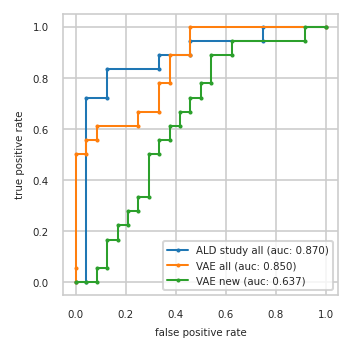

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.722   0.000 0.500   0.083 0.000
3          0.125 0.722   0.042 0.500   0.083 0.056
4          0.125 0.833   0.042 0.556   0.125 0.056
5          0.333 0.833   0.083 0.556   0.125 0.167
6          0.333 0.889   0.083 0.611   0.167 0.167
7          0.458 0.889   0.250 0.611   0.167 0.222
8          0.458 0.944   0.250 0.667   0.208 0.222
9          0.750 0.944   0.333 0.667   0.208 0.278
10         0.750 1.000   0.333 0.778   0.250 0.278
11         1.000 1.000   0.375 0.778   0.250 0.333
12           NaN   NaN   0.375 0.889   0.292 0.333
13           NaN   NaN   0.458 0.889   0.292 0.500
14           NaN   NaN   0.458 1.000   0.333 0.500
15           NaN   NaN   1.000 1.000   0.333 0.556
16           NaN   NaN     NaN   NaN   0.375 0.556
17           NaN   NaN     NaN   NaN   0.375 0.611
18           NaN   NaN     NaN   NaN   0.417 0.611
19           NaN   NaN     NaN   NaN   0.417 0.667
20           NaN   NaN     NaN   NaN   0.458 0.667
21           NaN   NaN     NaN   NaN   0.458 0.722
22           NaN   NaN     NaN   NaN   0.500 0.722
23           NaN   NaN     NaN   NaN   0.500 0.778
24           NaN   NaN     NaN   NaN   0.542 0.778
25           NaN   NaN     NaN   NaN   0.542 0.889
26           NaN   NaN     NaN   NaN   0.625 0.889
27           NaN   NaN     NaN   NaN   0.625 0.944
28           NaN   NaN     NaN   NaN   0.917 0.944
29           NaN   NaN     NaN   NaN   0.917 1.000
30           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P02741,B8ZZ19;H0Y3U0;P20472,O60512
2,Q9P2E7;Q9P2E7-2,P15086,Q9NUQ9
3,P61981,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
4,Q99983,P51688,Q96GD0
5,P04075,P04075,P31321
6,P14174,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,None,P14174,E9PK25;G3V1A4;P23528
8,None,Q14894,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


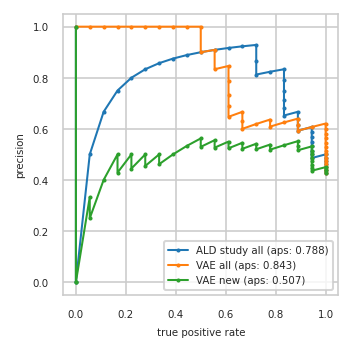

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.621 1.000     0.552 0.889
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.593 0.889     0.593 0.889     0.519 0.778
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.714 0.833     0.619 0.722     0.524 0.611
22         0.750 0.833     0.600 0.667     0.550 0.611
23         0.789 0.833     0.632 0.667     0.526 0.556
24         0.833 0.833     0.667 0.667     0.556 0.556
25         0.824 0.778     0.647 0.611     0.529 0.500
26         0.812 0.722     0.688 0.611     0.562 0.500
27         0.867 0.722     0.733 0.611     0.533 0.444
28         0.929 0.722     0.786 0.611     0.500 0.389
29         0.923 0.667     0.846 0.611     0.462 0.333
30         0.917 0.611     0.833 0.556     0.500 0.333
31         0.909 0.556     0.909 0.556     0.455 0.278
32         0.900 0.500     0.900 0.500     0.500 0.278
33         0.889 0.444     1.000 0.500     0.444 0.222
34         0.875 0.389     1.000 0.444     0.500 0.222
35         0.857 0.333     1.000 0.389     0.429 0.167
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.250 0.056
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


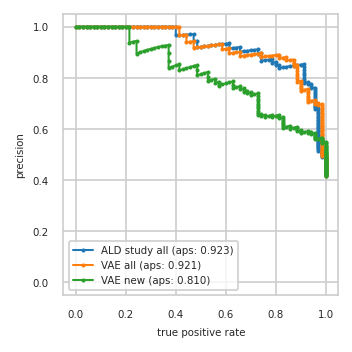

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


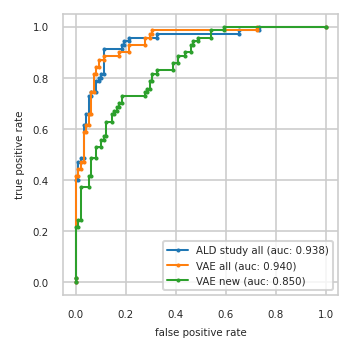

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}